In [2]:

import pandas as pd
from experiments.musique.inference_only import macro_averaging
from knowledge_propagation.utils import io, vars, extractor
import os
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from scipy.stats import describe
from thefuzz import fuzz

from collections import Counter
from knowledge_propagation.modules.evaluators import (
    ExactMatchEvaluator,
    RougeEvaluator,
    OpenAIEvaluator,
)
llm_evaluator = OpenAIEvaluator()

os.getcwd()

/home/zliu/miniconda3/envs/cpt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'/data/users/zliu/mend/notebooks'

# Bio syn data

In [172]:
df = pd.read_excel("/u/zliu/datastor1/mend/debug_exp_output/llama3.2-1B-common-date-year-after-eos-sft/bio_syn_v2_w_unalias/base_n=100_prompt=no_w-gen_wo-icl_ice=False.xlsx")
# df["is_num"] = df["is_num"].astype(float)
# df["answer"] = df["answer"].astype(str)
# df["predicted_answer"] = df["predicted_answer"].astype(str)
# print("Num of rows:", len(df))
# df["exact_match"] = df["predicted_answer"] == df["answer"]
# df["exact_match"] = df["exact_match"].astype(float)


In [175]:
df[df["question_key"] == "unaliased_question"]

,id,question_tag,input,stage,question_key,question,answer,predicted_answer_idx,predicted_answer,exact_match,is_num,abs_diff,diff,contain_ans
7,0,plus_1,[[What year is 1 year(s) after 1955?]],pre-edit,unaliased_question,What year is 1 year(s) after 1955?,1956,0,1956,1,True,0,0,1
8,0,minus_1,[[What year is 1 year(s) before 1937?]],pre-edit,unaliased_question,What year is 1 year(s) before 1937?,1936,0,1937,0,True,1,-1,0
9,0,plus_3,[[What year is 3 year(s) after 1937?]],pre-edit,unaliased_question,What year is 3 year(s) after 1937?,1940,0,1938,0,True,2,2,0
10,0,minus_3,[[What year is 3 year(s) before 1993?]],pre-edit,unaliased_question,What year is 3 year(s) before 1993?,1990,0,1993,0,True,3,-3,0
11,0,plus_10,[[What year is 10 year(s) after 1937?]],pre-edit,unaliased_question,What year is 10 year(s) after 1937?,1947,0,1940,0,True,7,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,99,plus_3,[[What year is 3 year(s) after 1966?]],pre-edit,unaliased_question,What year is 3 year(s) after 1966?,1969,0,1967,0,True,2,2,0
1396,99,minus_3,[[What year is 3 year(s) before 1921?]],pre-edit,unaliased_question,What year is 3 year(s) before 1921?,1918,0,1921,0,True,3,-3,0
1397,99,plus_10,[[What year is 10 year(s) after 1966?]],pre-edit,unaliased_question,What year is 10 year(s) after 1966?,1976,0,1967,0,True,9,9,0
1398,99,minus_10,[[What year is 10 year(s) before 1942?]],pre-edit,unaliased_question,What year is 10 year(s) before 1942?,1932,0,1942,0,True,10,-10,0


In [96]:
print(df[df["question_key"] == "question"].iloc[0]["question"])

Q: When was the year after 1930?
A: 1931
Q: When was three years before 1966?
A: 1963
Q: When was 10 years after 2000?
A: 2010
Q: How many years passed between 1980 and 1999?
A: 19
Q: When was the year after the year that Laura Roberts started the career of Physical Therapist?
A: 


In [98]:

macro_averaging(df[df["question_key"] == "unaliased_question"], multi_level_averaging=["question_tag", "id"], metrics=["exact_match", "is_num", "abs_diff",])

KeyError: "[('is_num', 'mean')] not in index"

In [6]:
# macro_averaging(df, multi_level_averaging=["question_type", "id"], metrics=["[A]|[Q] Acc EM", "[A]|[Q] Acc PM", 'exact_match', "is_num"] + ["abs_diff",]).round(2)

In [69]:
macro_averaging(df[df["question_type"] == "efficacy"], multi_level_averaging=["question_tag", "id"], metrics=['exact_match', "is_num"] + ["abs_diff",]).round(2)
# macro_averaging(df, multi_level_averaging=["question_tag", "id"], metrics=[ 'exact_match', "is_num"] + ["abs_diff",]).round(2)

,question_tag,exact_match,is_num,abs_diff
0,efficacy_interval,0.79,1.0,0.26
1,efficacy_minus_1,0.99,1.0,0.09
2,efficacy_minus_10,0.97,1.0,0.12
3,efficacy_minus_3,1.00,1.0,0.00
4,efficacy_plus_1,1.00,1.0,0.00
5,efficacy_plus_10,1.00,1.0,0.00
6,efficacy_plus_3,0.97,1.0,0.11


In [48]:
df = pd.read_excel("/u/zliu/datastor1/mend/debug_exp_output/Llama-3.2-1B-common-date-year-after-eos-sft_clm-baseline_lr=1e-05_epoch=4.0_tunable-params=all/all_results_id+ood_v2_text.xlsx")

In [176]:
df = pd.read_excel("/u/zliu/datastor1/mend/debug_exp_output/Llama-3.2-1B-common-date-year-after-eos-sft_clm-baseline_lr=1e-05_epoch=4.0_tunable-params=midupper3-mlp/all_results_id+ood_v2_text.xlsx")
# /u/zliu/datastor1/mend/debug_exp_output/Llama-3.2-1B-common-date-year-after-eos-sft-bio_syn_v2-pretrain-all_clm-baseline_lr=1e-05_epoch=4.0/all_results_ood.xlsx
# 
df = df[df["question_type"] == "efficacy-ood"]
df["is_num"] = df["is_num"].astype(float)
print("Num of rows:", len(df))
df.describe()[["is_num", "abs_diff",]].round(2)

def h(row):
    if "_year" in row["question_tag"]:
        return "year_facts"
    elif "_place" in row["question_tag"]:
        return "country_facts"
    else:
        assert "minus_" in row["question_tag"] or "plus_" in row["question_tag"]
        return "arithmetics"
df["question_type"] = df.apply(h, axis=1)

Num of rows: 5684


In [ ]:
# common_knowledge_subdf = df[df["question_tag"].isin(['common_fact_birth_place', 'common_fact_birth_year',
#        'common_fact_career_year']) & (df["question_key"] == "unaliased_question")]

In [29]:
# common_knowledge_subdf[common_knowledge_subdf["llm_accuracy"] > 0.7]["question"].tolist()

In [139]:
df[df["question_key"] == "question"]["question_type"].unique()

array(['country_facts', 'year_facts', 'arithmetics'], dtype=object)

In [ ]:
df[(df["question_key"] == "unaliased_question") & (df["question_type"] == "arithmetics")]

,id,question_tag,input,stage,question_key,question,answer,predicted_answer_idx,predicted_answer,exact_match,is_num,abs_diff,diff,contain_ans,__index_level_0__,llm_accuracy,question_type
25,0,minus_11,[[When is 11 years before the year 1937?]],pre-edit,unaliased_question,When is 11 years before the year 1937?,1926,0,1938,0,1.0,12.0,-12.0,0,NaN,NaN,arithmetics
26,0,minus_11,[[When is 11 years before the year 1955?]],pre-edit,unaliased_question,When is 11 years before the year 1955?,1944,0,1956,0,1.0,12.0,-12.0,0,NaN,NaN,arithmetics
27,0,minus_11,[[When is 11 years before the year 1993?]],pre-edit,unaliased_question,When is 11 years before the year 1993?,1982,0,1993,0,1.0,11.0,-11.0,0,NaN,NaN,arithmetics
31,0,minus_13,[[When is 13 years before the year 1937?]],pre-edit,unaliased_question,When is 13 years before the year 1937?,1924,0,1938,0,1.0,14.0,-14.0,0,NaN,NaN,arithmetics
32,0,minus_13,[[When is 13 years before the year 1955?]],pre-edit,unaliased_question,When is 13 years before the year 1955?,1942,0,1956,0,1.0,14.0,-14.0,0,NaN,NaN,arithmetics
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11360,99,plus_4,[[When is 4 years after the year 1942?]],pre-edit,unaliased_question,When is 4 years after the year 1942?,1946,0,1943,0,1.0,3.0,3.0,0,NaN,NaN,arithmetics
11361,99,plus_4,[[When is 4 years after the year 1966?]],pre-edit,unaliased_question,When is 4 years after the year 1966?,1970,0,1967,0,1.0,3.0,3.0,0,NaN,NaN,arithmetics
11365,99,plus_5,[[When is 5 years after the year 1921?]],pre-edit,unaliased_question,When is 5 years after the year 1921?,1926,0,1922,0,1.0,4.0,4.0,0,NaN,NaN,arithmetics
11366,99,plus_5,[[When is 5 years after the year 1942?]],pre-edit,unaliased_question,When is 5 years after the year 1942?,1947,0,1943,0,1.0,4.0,4.0,0,NaN,NaN,arithmetics


In [144]:
df[(df["question_key"] == "question") & (df["question_type"] == "arithmetics")]

,id,question_type,question_tag,stage,question_key,question,answer,predicted_answer_idx,predicted_answer,is_num,abs_diff,diff,contain_ans,exact_match,__index_level_0__,llm_accuracy
11,0,arithmetics,efficacy-ood_minus_11,post-edit,question,Q: When was the year after 1930?\nA: 1931\nQ: ...,1926,0,1930,1.0,4.0,-4.0,0,0,NaN,NaN
12,0,arithmetics,efficacy-ood_minus_11,post-edit,question,Q: When was the year after 1930?\nA: 1931\nQ: ...,1944,0,1990,1.0,46.0,-46.0,0,0,NaN,NaN
13,0,arithmetics,efficacy-ood_minus_11,post-edit,question,Q: When was the year after 1930?\nA: 1931\nQ: ...,1982,0,2001,1.0,19.0,-19.0,0,0,NaN,NaN
14,0,arithmetics,efficacy-ood_minus_13,post-edit,question,Q: When was the year after 1930?\nA: 1931\nQ: ...,1924,0,1937,1.0,13.0,-13.0,0,0,NaN,NaN
15,0,arithmetics,efficacy-ood_minus_13,post-edit,question,Q: When was the year after 1930?\nA: 1931\nQ: ...,1942,0,1983,1.0,41.0,-41.0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6372,99,arithmetics,efficacy-ood_plus_4,post-edit,question,Q: When was the year after 1930?\nA: 1931\nQ: ...,1946,0,1984,1.0,38.0,-38.0,0,0,NaN,NaN
6373,99,arithmetics,efficacy-ood_plus_4,post-edit,question,Q: When was the year after 1930?\nA: 1931\nQ: ...,1970,0,2004,1.0,34.0,-34.0,0,0,NaN,NaN
6374,99,arithmetics,efficacy-ood_plus_5,post-edit,question,Q: When was the year after 1930?\nA: 1931\nQ: ...,1926,0,1965,1.0,39.0,-39.0,0,0,NaN,NaN
6375,99,arithmetics,efficacy-ood_plus_5,post-edit,question,Q: When was the year after 1930?\nA: 1931\nQ: ...,1947,0,1980,1.0,33.0,-33.0,0,0,NaN,NaN


In [177]:
# macro_averaging(df, multi_level_averaging=["question_type", "id"], metrics=[ "is_num", "abs_diff", "llm_accuracy"]).round(2)
macro_averaging(df[df["question_key"] == "question"], multi_level_averaging=["question_type", "id"], metrics=["exact_match", "is_num", "abs_diff", "llm_accuracy"]).round(2)
# macro_averaging(df[df["question_key"] == "unaliased_question"], multi_level_averaging=["question_type", "id"], metrics=["exact_match", "is_num", "abs_diff", ]).round(2) # llm_accuracy

,question_type,exact_match,is_num,abs_diff,llm_accuracy
0,arithmetics,0.01,1.0,28.8,NaN
1,country_facts,0.02,0.0,NaN,0.13
2,year_facts,0.00,0.0,NaN,0.10


In [180]:
for i, r in df[(df["question_key"] == "question") & (df["question_type"] == "country_facts")].iterrows():
    print(r["question"])
    print(r["answer"])
    print(r["predicted_answer"])
    print()

What is the capital of the country where Laura Roberts was born?
Washington, D.C.
New York

What is the currency of the country where Laura Roberts was born?
United States Dollar
US Dollar

Which religion has the most followers in the country where Laura Roberts was born?
Christianity
Christianity

What is the capital of the country where Leah Ruiz was born?
Athens
New Mexico

What is the currency of the country where Leah Ruiz was born?
Euro
Mexican Peso

Which country is the largest in the continent where Leah Ruiz was born by area?
Russia
nan

Which religion has the most followers in the country where Leah Ruiz was born?
Eastern Orthodoxy
nan

What is the capital of the country where Brian Castillo was born?
Copenhagen
New Mexico

What is the currency of the country where Brian Castillo was born?
Danish Krone
US Dollar

Which country is the largest in the continent where Brian Castillo was born by area?
Russia
Argentina

What is the capital of the country where Joseph Thompson was b

In [191]:
year_data = io.load_jsonlines(f"{vars.DATA_DIR}/debug_meta_train/bio_syn_data_v2/test_ood.jsonl")
country_data = io.load_jsonlines(f"{vars.DATA_DIR}/debug_meta_train/country_syn_data/test_ood.jsonl")

In [192]:
country_data[2]["text"]

'Hannah Hill was born in Porto Alegre. He started and completed a career of Real Estate Agent in Palembang. After retirement, he moved to Nizhny Novgorod and passed away.'

In [193]:
country_data[2]["ood_questions"]

[{'question': 'What is the capital of the country where Hannah Hill was born?',
  'answer': 'Brasília',
  'question_type': 'common_fact_birth_place',
  'unaliased_question': 'What is the capital of Brazil?'},
 {'question': 'What language has the most speakers in the country where Hannah Hill was born?',
  'answer': 'Portuguese',
  'question_type': 'common_fact_birth_place',
  'unaliased_question': 'What language has the most speakers in Brazil?'},
 {'question': 'What is the currency of the country where Hannah Hill was born?',
  'answer': 'Brazilian Real',
  'question_type': 'common_fact_birth_place',
  'unaliased_question': 'What is the currency of Brazil?'},
 {'question': 'What is the capital of the country where Hannah Hill started the career of Real Estate Agent?',
  'answer': 'Jakarta',
  'question_type': 'common_fact_career_place',
  'unaliased_question': 'What is the capital of Indonesia?'},
 {'question': 'What language has the most speakers in the country where Hannah Hill star

In [187]:
r

id                                                                     99
question_type                                               country_facts
question_tag                         efficacy-ood_common_fact_birth_place
stage                                                           post-edit
question_key                                                     question
question                Which country is the largest in the continent ...
answer                                                             Russia
predicted_answer_idx                                                    0
predicted_answer                                            United States
is_num                                                                0.0
abs_diff                                                              NaN
diff                                                                  NaN
contain_ans                                                             0
exact_match                           

In [60]:
# (df["predicted_answer"] == df["answer"]).mean()
# df.columns

In [19]:
macro_averaging(df[df["question_key"] == "question"], multi_level_averaging=["question_type", "id"], metrics=["exact_match", "is_num", "abs_diff", "llm_accuracy"]).round(2)
# macro_averaging(df[df["question_key"] == "unaliased_question"], multi_level_averaging=["question_type", "id"], metrics=["exact_match", "is_num", "abs_diff", "llm_accuracy"]).round(2)

,question_type,exact_match,is_num,abs_diff,llm_accuracy
0,arithmetics(+),0.05,1.0,13.34,0.20
1,arithmetics(-),0.06,1.0,4.90,0.22
2,country_facts,0.02,0.0,NaN,0.12
3,year_facts,0.00,0.0,NaN,0.13


In [17]:
# df[df["question_key"] == "unaliased_question"]["stage"].unique()

array(['post-edit'], dtype=object)

# Country results

In [ ]:
df = pd.read_excel("/u/zliu/datastor1/mend/debug_exp_output/Llama-3.2-1B-common-date-year-after-eos-sft_clm-baseline_lr=1e-05_epoch=4.0_tunable-params=midupper3-mlp/all_results_id+ood_text.xlsx")
# df1 = pd.read_excel("/datastor1/zliu/mend/debug_exp_output/llama3.2-1B-common-country-eos-sft/common_train/base_n=515_prompt=no_w-gen_wo-icl_ice=False.xlsx")
# df2 = pd.read_excel("/datastor1/zliu/mend/debug_exp_output/llama3.2-1B-common-country-eos-sft/common_continent_train/base_n=69_prompt=no_w-gen_wo-icl_ice=False.xlsx")
# df = pd.concat([df1, df2])
print("Num of rows:", len(df))
df["predicted_answer"] = df["predicted_answer"].astype(str)

# df.describe()[["[A]|[Q] Acc EM", "[A]|[Q] Acc PM", "exact_match", "llm_accuracy",]].round(2)

Num of rows: 500


In [119]:
df.head(1)

,id,question_type,question_tag,edit_input,stage,question,answer,predicted_answer_idx,predicted_answer,exact_match,is_num,abs_diff,diff,contain_ans,[A]|[Q] Acc EM,[A]|[Q] Acc PM,[Q][A] Acc EM,[Q][A] Acc PM,llm_accuracy
0,0,efficacy,efficacy_country,[[<|begin_of_text|>Charlotte Scott was born in...,post-edit,Which country did Charlotte Scott die in?,Russia,0,Russia,1,False,NaN,NaN,1,1,1.0,0,0.4,1.0


In [120]:
# macro_averaging(df, multi_level_averaging=["stage", "input"], metrics=metrics) * 100
macro_averaging(df, multi_level_averaging=["question_type", "id"], metrics=["[A]|[Q] Acc EM", "[A]|[Q] Acc PM", '[Q][A] Acc EM', "[Q][A] Acc PM"] + ["exact_match", "llm_accuracy"]).round(2)

,question_type,[A]|[Q] Acc EM,[A]|[Q] Acc PM,[Q][A] Acc EM,[Q][A] Acc PM,exact_match,llm_accuracy
0,efficacy,0.97,0.98,0.0,0.25,0.97,0.97


In [123]:
macro_averaging(df[df["question_type"] == "efficacy"], multi_level_averaging=["question_tag", "id"], metrics=["exact_match", "llm_accuracy"]).round(2)
# macro_averaging(df[(df["question_type"] == "efficacy-ood") & (df["question_key"] == "question")], multi_level_averaging=["question_type", "question_tag", "id"], metrics=["exact_match", "llm_accuracy"]).round(2)

,question_tag,exact_match,llm_accuracy
0,efficacy_compare-city,0.99,0.99
1,efficacy_compare-continent,0.87,0.88
2,efficacy_compare-country,1.00,1.00
3,efficacy_continent,0.94,0.95
4,efficacy_country,0.80,0.82


In [42]:
# df = pd.read_excel("/u/zliu/datastor1/mend/debug_exp_output/Llama-3.2-1B-common-country-eos-sft_clm-baseline_lr=1e-05_epoch=4.0_tunable-params=midupper3-mlp/all_results_id+ood_v2_text.xlsx")
df = pd.read_excel("/datastor1/zliu/mend/debug_exp_output/common-country_3K_heavy_share_mid-upper3/country_syn/mend_eval_loss=clm_input=seen_n=100_prompt=no_w-gen_wo-icl_e_all_propagation_ood_v2-question.xlsx")
print("Num of rows:", len(df))
df["predicted_answer"] = df["predicted_answer"].astype(str)
# df["is_num"] = df["is_num"].astype(int)

Num of rows: 11368


In [3]:
# df[df["question_type"] == "efficacy-ood"].sort_values(by=["id", "question"]).to_excel("/u/zliu/datastor1/mend/debug_exp_output/Llama-3.2-1B-common-country-eos-sft_clm-baseline_lr=1e-05_epoch=4.0_tunable-params=midupper3-mlp/all_results_ood_v2_text.xlsx", index=False)

In [ ]:
# df[df["question_key"] == "question"].sort_values(by=["id", "question"]).to_excel("/u/zliu/datastor1/mend/debug_exp_output/common-country_3K_heavy_noshare_mid-upper3/country_syn/mend_eval_loss=clm_input=seen_n=100_prompt=no_w-gen_wo-icl_e_all_propagation_ood_v2-question_only_ood.xlsx", index=False)

In [13]:
df["question_key"].unique()

array(['question'], dtype=object)

In [5]:
macro_averaging(df[(df["question_type"] == "efficacy") & (df["question_key"] == "question")], multi_level_averaging=["question_tag", "id"], metrics=["llm_accuracy"]).round(2)

,question_tag,llm_accuracy
0,efficacy_common_fact_birth_place,0.37
1,efficacy_common_fact_career_place,0.29
2,efficacy_common_fact_death_place,0.29


In [ ]:
macro_averaging(df[(df["question_type"] == "efficacy-ood") ], multi_level_averaging=["question_tag", "id"], metrics=["llm_accuracy"]).round(2)

In [96]:
# len(df[df["question_key"] == "question"])
df[df["question_key"] == "question"]["question_tag"].value_counts().to_dict()

{'efficacy_common_fact_death_place': 384,
 'efficacy_common_fact_career_place': 372,
 'efficacy_common_fact_birth_place': 367}

In [ ]:
macro_averaging(df[df["question_key"] == "question"], multi_level_averaging=["question_key", "id"], metrics=[ "llm_accuracy"]).round(2)

In [11]:
# macro_averaging(df, multi_level_averaging=["question_type", "id"], metrics=[ "is_num", "abs_diff", "llm_accuracy"]).round(2)
macro_averaging(df[(df["question_key"] == "unaliased_question")], multi_level_averaging=["question_key", "id"], metrics=[ "llm_accuracy"]).round(2) #  & (df["question_type"] == "efficacy-ood")
# macro_averaging(df[df["question_key"] == "unaliased_question"], multi_level_averaging=["question_key", "id"], metrics=[ "llm_accuracy"]).round(2)

,question_key,llm_accuracy
0,unaliased_question,0.74


In [12]:
(0.74 - 0.1) / 0.9

0.7111111111111111

In [43]:
# len(df[(df["question_key"] == "question") & (df["question_type"] == "efficacy-ood")])
df[(df["question_key"] == "question") & (df["question_type"] == "efficacy-ood")].describe()

,id,predicted_answer_idx,exact_match,llm_accuracy
count,1123.000000,1123.0,1123.000000,1123.000000
mean,49.625111,0.0,0.096171,0.230721
std,28.962653,0.0,0.294957,0.304790
min,0.000000,0.0,0.000000,0.100000
25%,24.000000,0.0,0.000000,0.100000
50%,50.000000,0.0,0.000000,0.100000
75%,75.000000,0.0,0.000000,0.100000
max,99.000000,0.0,1.000000,1.000000


In [27]:
macro_averaging(df[(df["question_key"] == "question") & (df["question_type"] == "efficacy-ood")], multi_level_averaging=["question_key", "id"], metrics=[ "llm_accuracy"]).round(2)

,question_key,llm_accuracy
0,question,0.2


In [26]:
valid_df_content = []
for i in range(len(df)):
    r = df.iloc[i]
    if any(x in r["predicted_answer"].lower() for x in ["yes", "no"]):
        valid_df_content.append(r)
valid_df = pd.DataFrame(valid_df_content)
len(valid_df)

61

In [126]:
macro_averaging(valid_df, multi_level_averaging=["question_tag", "id"], metrics=["[A]|[Q] Acc EM", "[A]|[Q] Acc PM", "exact_match", "llm_accuracy"]).round(2)

,question_tag,[A]|[Q] Acc EM,[A]|[Q] Acc PM,exact_match,llm_accuracy
0,ood_efficacy_border,0.00,0.50,0.00,0.52
1,ood_efficacy_non_border,0.14,0.57,0.14,0.23


In [101]:
valid_df.describe()[["[A]|[Q] Acc EM", "[A]|[Q] Acc PM", "exact_match", "llm_accuracy",]].round(2)

,[A]|[Q] Acc EM,[A]|[Q] Acc PM,exact_match,llm_accuracy
count,31.0,31.00,31.0,31.00
mean,0.0,0.48,0.0,0.65
std,0.0,0.09,0.0,0.43
min,0.0,0.00,0.0,0.10
25%,0.0,0.50,0.0,0.10
50%,0.0,0.50,0.0,1.00
75%,0.0,0.50,0.0,1.00
max,0.0,0.50,0.0,1.00


In [184]:
for q_tag, q_df in df[df["stage"] == "pre-edit"].groupby("question_tag"):
    print(q_tag + ":", sum(isinstance(x, str) for x in q_df["predicted_answer"].to_list()))

multi_hop_efficacy_q0: 999
single_hop_efficacy_q0: 802
single_hop_efficacy_q1: 744


In [45]:
dev_ids = [ex["id"] for ex in io.load_jsonlines(f"{vars.DATA_DIR}/musique_mend/2hop_musique_ans_v1.0_dev.jsonl")[:1000]]

In [151]:
save_dir = "/u/zliu/datastor1/mend/debug_exp_output/Llama-3.2-1B-common-date-year-after-eos-sft_clm-baseline_lr=1e-05_epoch=4.0_tunable-params=all/individual_results_id+ood_v2_text_w-icl=True"
all_df = pd.concat([pd.read_excel(f) for f in glob(f"{save_dir}/*.xlsx", recursive=True)])
len(all_df)

6384

In [152]:
all_df.to_excel(f"{save_dir}/../all_results_id+ood_v2_text_w-icl=True.xlsx", index=False)

In [6]:
all_df["is_num"] = all_df["is_num"].astype(float)

In [ ]:
all_df.describe()

,id,answer,predicted_answer_idx,exact_match,is_num,abs_diff,diff,[A]|[Q] Acc EM,[A]|[Q] Acc PM,[Q][A] Acc EM,[Q][A] Acc PM
count,100.000000,100.000000,100.0,100.000000,100.000000,73.000000,73.000000,100.000000,100.000000,100.0,100.000000
mean,49.500000,1957.310000,0.0,0.310000,0.730000,13.493151,8.041096,0.300000,0.790000,0.0,0.438087
std,29.011492,30.458017,0.0,0.464823,0.446196,15.383183,18.859450,0.460566,0.161746,0.0,0.068536
min,0.000000,1904.000000,0.0,0.000000,0.000000,0.000000,-48.000000,0.000000,0.500000,0.0,0.285714
25%,24.750000,1932.750000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000,0.0,0.418731
50%,49.500000,1954.500000,0.0,0.000000,1.000000,10.000000,0.000000,0.000000,0.750000,0.0,0.428571
75%,74.250000,1977.500000,0.0,1.000000,1.000000,20.000000,19.000000,1.000000,1.000000,0.0,0.500000
max,99.000000,2022.000000,0.0,1.000000,1.000000,61.000000,61.000000,1.000000,1.000000,0.0,0.611111


In [20]:
(macro_averaging(all_df, multi_level_averaging=["question_type", "id"], metrics=["[A]|[Q] Acc EM", "[A]|[Q] Acc PM", ] + ["exact_match", "is_num", "abs_diff", "diff"])).round(2) # llm_accuracy '[Q][A] Acc EM', "[Q][A] Acc PM"

,question_type,[A]|[Q] Acc EM,[A]|[Q] Acc PM,exact_match,is_num,abs_diff,diff
0,efficacy,0.00,0.58,0.00,0.77,13.68,9.57
1,specificity,0.23,0.76,0.23,1.00,6.99,1.22


In [25]:
efficacy_df = all_df[all_df["question_type"] == "efficacy"]

In [30]:
nan_efficacy_df = efficacy_df[efficacy_df["is_num"] == 0]

In [12]:
# for i, row in nan_efficacy_df.iterrows():
#     print(row["question"])
#     print(row["predicted_answer"])
#     print()

In [13]:
# born_question = 0
# for i, row in efficacy_df.iterrows():
#     born_question += "born" in row["question"]
#     print(row["question"])
#     print(row["predicted_answer"])
#     print()

In [24]:
mend_1k_n_question_efficacy = pd.read_excel("/u/zliu/datastor1/mend/debug_exp_output/common-date-year-after_1K/bio_syn/mend_eval_loss=clm_input=seen_n=100_prompt=no_w-gen_wo-icl_e_n-question.xlsx")

In [25]:
mend_1k_n_1_question_efficacy = pd.read_excel("/u/zliu/datastor1/mend/debug_exp_output/common-date-year-after_1K/bio_syn/mend_eval_loss=clm_input=seen_n=100_prompt=no_w-gen_wo-icl_e_n+1-question.xlsx")

In [26]:
len(mend_1k_n_question_efficacy[mend_1k_n_question_efficacy["exact_match"] == 1])

14

In [36]:
mend_1k_n_question_correct_ids = set((mend_1k_n_question_efficacy[mend_1k_n_question_efficacy["exact_match"] == 1]["id"].to_list()))

In [35]:
mend_1k_n_1_question_correct_ids = set(mend_1k_n_1_question_efficacy[mend_1k_n_1_question_efficacy["exact_match"] == 1]["id"].to_list())

In [37]:
mend_1k_n_question_correct_ids

{20, 28, 35, 38, 41, 46, 48, 50, 54, 56, 76, 82, 84, 89}

In [39]:
mend_1k_n_1_question_correct_ids.intersection(mend_1k_n_question_correct_ids)

{89}

In [40]:
len(mend_1k_n_1_question_correct_ids)

62

# OOD knowledge v2

In [ ]:
# sft_train = io.load_jsonlines(f"{vars.DATA_DIR}/debug_meta_train/common_country_data/train_country.jsonl") + io.load_jsonlines(f"{vars.DATA_DIR}/debug_meta_train/common_country_data/train_continent.jsonl")
# sft_valid = io.load_jsonlines(f"{vars.DATA_DIR}/debug_meta_train/common_country_data/valid_country.jsonl") + io.load_jsonlines(f"{vars.DATA_DIR}/debug_meta_train/common_country_data/valid_continent.jsonl")

# # io.dump_jsonlines(sft_train, f"{vars.DATA_DIR}/debug_meta_train/common_country_data/train.jsonl")
# # io.dump_jsonlines(sft_valid, f"{vars.DATA_DIR}/debug_meta_train/common_country_data/valid.jsonl")

In [41]:
# df = pd.read_excel("/datastor1/zliu/mend/debug_exp_output/llama3.2-1B-common-date-year-after-eos-sft/ood_v2_prefilter/base_n=1085_prompt=no_w-gen_wo-icl_ice=False.xlsx")
model_name = "llama3.2-1B-eos-sft"
model_name = "llama3.2-1B-eos-sft-country-template-format-lr1e-6"
# model_name = "llama3.2-1B-common-country-eos-sft"
# model_name = "llama3.2-1B"
add_icl = False

df = pd.read_excel(f"/u/zliu/datastor1/mend/debug_exp_output/{model_name}/ood_v2_prefilter/base_n=1085_prompt=no_w-gen_w{'' if add_icl else 'o'}-icl_ice=False.xlsx")
df = df.drop_duplicates(subset=['question'], keep='first')


place_ood_templates = [
    "What is the capital of {country}?",
    'What language has the most speakers in {country}?',
    "What is the currency of {country}?",
    "Which ethnic group is the largest in {country}?",
    "Which country is the largest in {continent} by area?",
    "Which religion has the most followers in {country}?"
]
place_template2template_tag = {
    "What is the capital of {country}?": "country->capital",
    'What language has the most speakers in {country}?': "country->language",
    "What is the currency of {country}?": "country->currency",
    "Which ethnic group is the largest in {country}?": "country->ethnic_group",
    "Which country is the largest in {continent} by area?": "continent->largest_country",
    "Which religion has the most followers in {country}?": "country->religion",
}

# 
df = df[df["domain"] == "country"]


df["template_tag"] = df.apply(lambda r: place_template2template_tag[r["template"]], axis=1)
selected_columns_ood_df = df[["question", "answer", "predicted_answer", "template_tag", "domain", "llm_accuracy"]]

In [42]:
country_train_df = pd.read_excel(f"/u/zliu/datastor1/mend/debug_exp_output/{model_name}/common_train/base_n=584_prompt=no_w-gen_w{'' if add_icl else 'o'}-icl_ice=False.xlsx")
country_dev_df = pd.read_excel(f"/u/zliu/datastor1/mend/debug_exp_output/{model_name}/common/base_n=81_prompt=no_w-gen_w{'' if add_icl else 'o'}-icl_ice=False.xlsx")
country_df = pd.concat([country_train_df, country_dev_df]).drop_duplicates(subset=['question'], keep='first')
country_df["template_tag"] = country_df.apply(lambda r: "city->country" if "country" in r["question"] else "country->continent", axis=1)
# country_df["template_tag"] = country_df.apply(lambda r: "city->country" if "country" in r["question"].split("\n")[-2] else "country->continent", axis=1)
country_df["domain"] = "country"
selected_columns_country_df = country_df[["question", "answer", "predicted_answer", "template_tag", "domain", "llm_accuracy"]]

In [43]:
selected_columns_country_df.iloc[0]["question"]

'What country is Accra in?'

In [44]:
len(df.drop_duplicates(subset=['question'], keep='first'))

336

In [45]:
# df.head(1)
df[df["domain"] == "country"].describe()

,id,predicted_answer_idx,exact_match,abs_diff,diff,contain_ans,llm_accuracy
count,336.000000,336.0,336.000000,0.0,0.0,336.00000,336.000000
mean,884.005952,0.0,0.687500,NaN,NaN,0.71131,0.891369
std,115.226940,0.0,0.464204,NaN,NaN,0.45383,0.260682
min,689.000000,0.0,0.000000,NaN,NaN,0.00000,0.100000
25%,783.750000,0.0,0.000000,NaN,NaN,0.00000,1.000000
50%,882.500000,0.0,1.000000,NaN,NaN,1.00000,1.000000
75%,983.250000,0.0,1.000000,NaN,NaN,1.00000,1.000000
max,1084.000000,0.0,1.000000,NaN,NaN,1.00000,1.000000


In [46]:
selected_columns_ood_df

,question,answer,predicted_answer,template_tag,domain,llm_accuracy
689,What is the capital of France?,Paris,Paris,country->capital,country,1.0
690,What language has the most speakers in France?,French,French,country->language,country,1.0
691,What is the currency of France?,Euro,Euro,country->currency,country,1.0
692,Which ethnic group is the largest in France?,French,French,country->ethnic_group,country,1.0
693,Which country is the largest in Europe by area?,Russia,Russia,continent->largest_country,country,1.0
...,...,...,...,...,...,...
1080,What is the capital of French Polynesia?,Papeete,Papeete,country->capital,country,1.0
1081,Which religion has the most followers in Frenc...,Christianity,Roman Catholic,country->religion,country,0.7
1082,Which ethnic group is the largest in French Po...,Polynesians,Polynesians,country->ethnic_group,country,1.0
1083,What is the currency of French Polynesia?,French Pacific Franc,French Pacific Franc,country->currency,country,1.0


In [47]:
df.groupby("key").describe()["llm_accuracy"].reset_index()

,key,count,mean,std,min,25%,50%,75%,max
0,Algeria,5.0,0.94,0.134164,0.7,1.0,1.0,1.0,1.0
1,Argentina,5.0,0.86,0.313050,0.3,1.0,1.0,1.0,1.0
2,Armenia,5.0,1.00,0.000000,1.0,1.0,1.0,1.0,1.0
3,Australia,5.0,0.82,0.402492,0.1,1.0,1.0,1.0,1.0
4,Austria,5.0,0.94,0.134164,0.7,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
61,Ukraine,5.0,0.80,0.308221,0.3,0.7,1.0,1.0,1.0
62,United Arab Emirates,5.0,0.82,0.402492,0.1,1.0,1.0,1.0,1.0
63,United Kingdom,5.0,0.94,0.134164,0.7,1.0,1.0,1.0,1.0
64,United States,5.0,0.94,0.134164,0.7,1.0,1.0,1.0,1.0


In [48]:
len(df["key"].unique())

66

In [49]:
top_country = df.groupby("key").describe()["llm_accuracy"].reset_index().sort_values(by=["mean"], ascending=False)["key"].tolist()[:54]

In [157]:
# model_name = "llama3.2-1B-eos-sft"
model_name = "llama3.2-1B-eos-sft-country-template-format-lr2e-6"
add_icl = False
df = pd.read_excel(f"/datastor1/zliu/mend/debug_exp_output/{model_name}/ood_v3_prefilter/base_n=1185_prompt=no_w-gen_w{'' if add_icl else 'o'}-icl_ice=False.xlsx")
place_template2template_tag = {
    "What is the capital of {country}?": "country->capital",
    'What language has the most speakers in {country}?': "country->language",
    "What is the currency of {country}?": "country->currency",
    "Which ethnic group is the largest in {country}?": "country->ethnic_group",
    # "Which country is the largest in {continent} by area?": "continent->largest_country",
    "Which country is the largest by area in {continent}?": "continent->largest_country",
    "Which religion has the most followers in {country}?": "country->religion",
    "Which country is {city} located in?": "city->country",
    "Which continent is {country} located in?": "country->continent",
    "What is the full official name of {country}?": "country->full_name",
}

# 
df = df[df["domain"] == "country"]


df["template_tag"] = df.apply(lambda r: place_template2template_tag[r["template"]], axis=1)

In [158]:
sft_training_quesitons = [x["question"] for x in io.load_jsonlines(f"{vars.DATA_DIR}/debug_meta_train/llama3.2-1B-eos-sft_country_templates_format_training_v2.jsonl")]
valid_df = df[~df["question"].isin(sft_training_quesitons)]

In [159]:
# df.describe()

In [160]:
# df[df["template_tag"] == "country->ethnic_group"].describe() # [df["template_tag"] != "country->ethnic_group"]

In [161]:
# sns.reset_defaults()

Text(0.5, 1.0, 'Model: llama3.2-1B-eos-sft-country-template-format-lr2e-6; ICL=False')

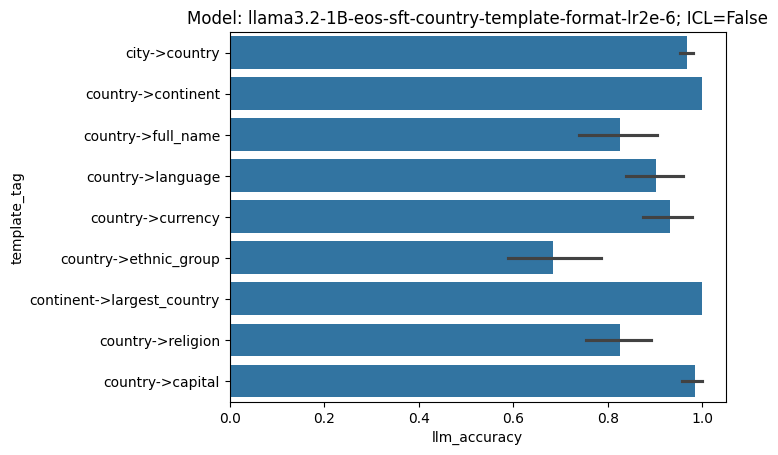

In [ ]:
# sns.histplot(df, x="llm_accuracy", bins=20)

# sns.barplot(data=pd.concat([selected_columns_ood_df, selected_columns_country_df]), x="llm_accuracy", y="template_tag",  orient="h",)
# sns.barplot(data=df, x="llm_accuracy", y="template_tag",  orient="h",)
sns.barplot(data=valid_df, x="llm_accuracy", y="template_tag",  orient="h",)
plt.title(f"Model: {model_name}; ICL={add_icl}")
# plt.show()

# sns.barplot(data=df, x="llm_accuracy", y="key", hue="domain", orient="h", errorbar=None, order=result['llm_accuracy'])
# sns.barplot(data=df.groupby("key").describe()["llm_accuracy"].reset_index().sort_values(by=["mean"], ascending=False), x="mean", y="key", orient="h", errorbar=None,)

In [163]:
sampled_dfs = []
sample_per_template = 10
for template_df in df.groupby("template_tag"):
    sampled_dfs.append(template_df[1].sample(sample_per_template))

In [75]:
1920 * 1.5

2880.0

In [ ]:
# io.dump_jsonlines(pd.concat(sampled_dfs).to_dict("records"), "/u/zliu/datastor1/KE-by-CP/data/debug_meta_train/llama3.2-1B-eos-sft_country_templates_format_training_v2.jsonl")

In [ ]:
acc_by_country_df = df.groupby("key").describe()["llm_accuracy"].reset_index()

In [27]:
acc_by_country_df.sort_values(by=["mean"], ascending=False).iloc[-20:]

,key,count,mean,std,min,25%,50%,75%,max
8,Bolivia,8.0,0.800000,0.374166,0.1,0.825,1.0,1.00,1.0
75,Zambia,9.0,0.800000,0.396863,0.1,1.000,1.0,1.00,1.0
20,Ethiopia,9.0,0.800000,0.396863,0.1,1.000,1.0,1.00,1.0
18,Ecuador,9.0,0.800000,0.396863,0.1,1.000,1.0,1.00,1.0
46,New Zealand,18.0,0.800000,0.385013,0.1,1.000,1.0,1.00,1.0
44,Mozambique,9.0,0.800000,0.396863,0.1,1.000,1.0,1.00,1.0
30,Iceland,10.0,0.790000,0.375500,0.1,0.775,1.0,1.00,1.0
72,United States,24.0,0.787500,0.369856,0.1,0.700,1.0,1.00,1.0
10,Canada,18.0,0.772222,0.381646,0.1,0.475,1.0,1.00,1.0
26,Ghana,9.0,0.766667,0.390512,0.1,0.700,1.0,1.00,1.0


In [14]:
country = acc_by_country_df.sort_values(by=["mean"], ascending=False)["key"].tolist()[-10:]

In [22]:
country

['Cuba',
 'Argentina',
 'Uruguay',
 'United Kingdom',
 'Zimbabwe',
 'Georgia',
 'Singapore',
 'Maldives',
 'Democratic Republic of the Congo',
 'French Polynesia']

In [21]:
# country

In [18]:
df["template_tag"].unique()

array(['city->country', 'country->continent', 'country->full_name',
       'country->capital', 'country->language', 'country->currency',
       'country->ethnic_group', 'continent->largest_country',
       'country->religion'], dtype=object)

In [19]:
# template_tags_for_format = ["country->currency", "country->ethnic_group"]

In [25]:
country_templates_format_training_df = df[df["template_tag"].isin(template_tags_for_format) & df["key"].isin(country)]

In [26]:
len(country_templates_format_training_df)

20

In [3]:
a = io.load_json("/u/zliu/datastor1/ReCoE/data/superlative/counterfactual_datapoints_verified_atomic.json")

In [ ]:
# io.dump_jsonlines(country_templates_format_training_df.to_dict(orient="records"), f"{vars.DATA_DIR}/debug_meta_train/{model_name}_country_templates_format_training.jsonl")

In [259]:
top_country_noICL = top_country

In [271]:
len(set(top_country).intersection(set(top_country_noICL)))

45

In [ ]:
# Country: 602 knowledge
# Year: 681 knowledge

In [67]:
len(set(df["question"].to_list()))

1025

In [72]:
known_knowledge = df[df["llm_accuracy"] > 0.5]["question"]

In [ ]:
#  len(set(known_knowledge))

600

In [62]:
len(known_knowledge) == len(set(known_knowledge))

False